<a href="https://colab.research.google.com/github/sadaallosaioa/Mineria_Datos/blob/main/Actividad_2_Miner%C3%ADa_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importación de librerías**
(Importo las mismas que las del ejemplo de las tres especies de Iris y también la "random" que usaré)


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering, AgglomerativeClustering, OPTICS, cluster_optics_dbscan, Birch, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import random

# **2. Carga del dataset y comprobaciones varias**
... Tras quitar un buen número de columnas de la base de datos original (que estaba en https://www.educacionyfp.gob.es/inee/dam/jcr:70dae5d2-2971-45c9-be91-4bac9a0127ad/EGD09.xlsx), añadir una única columna, y cambiar el formato a csv (además de las comas decimales por puntos), me quedó el archivo BD1recortada.csv (de 8,5 Mb que está disponible en mi repositorio de [GitHub](https://github.com/sadaallosaioa/Mineria_Datos/blob/main/BD1recortada.csv))

Subo el archivo y lo cargo:

In [ ]:
dfBD1 = pd.read_csv("sample_data/BD1recortada.csv", sep = ';')

Números de filas y columnas:

In [ ]:

dfBD1.shape

(28708, 53)

Nombres y tipos de columnas:

In [ ]:
dfBD1.dtypes

CENTROA                      int64
GRUPO                        int64
ALUMNO                       int64
TITULAR                      int64
CUESTALU                   float64
P4A_lugar_nacimiento       float64
P17_edad_escolarizacion    float64
P18_repetidor              float64
P24A                       float64
P24B                       float64
P24C                       float64
P24D                       float64
P24E                       float64
P24F                       float64
P24G                       float64
P24H                       float64
P25A                       float64
P25B                       float64
P25C                       float64
P25D                       float64
P25E                       float64
P25F                       float64
P30A                       float64
P30B                       float64
P30C                       float64
P30D                       float64
P30E                       float64
PP02_edad                  float64
PP04_antigdad       

Todo es correcto:


*   3 identificadores de colegio, grupo y alumno
*   Otros de contexto del cada alumno
*   Las respuestas al cuestionario sobre el profesorado de cada alumno (desde P24A a P30E
*   4 de contexto del profesorado
*   El ISEC de cada alumno
*   Las 20 calificaciones (desde PV1ling hasta PV5syc) además del recuento de cuántas de ellas se han cumplimentado






*   Elemento de lista



In [ ]:
dfBD1.tail()

,CENTROA,GRUPO,ALUMNO,TITULAR,CUESTALU,P4A_lugar_nacimiento,P17_edad_escolarizacion,P18_repetidor,P24A,P24B,...,PV2mfis,PV3mfis,PV4mfis,PV5mfis,PV1syc,PV2syc,PV3syc,PV4syc,PV5syc,calificaciones
28703,900,2,19,1,1.0,4.0,3.0,1.0,4.0,4.0,...,514.304113,504.847000,520.726233,483.060475,498.766176,442.987970,487.070886,448.222440,475.228601,20
28704,900,2,20,1,1.0,4.0,1.0,1.0,4.0,4.0,...,357.907570,372.180065,349.184110,384.914057,412.392223,373.130581,428.322560,447.289471,401.832757,20
28705,900,2,21,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
28706,900,2,22,1,1.0,4.0,3.0,2.0,4.0,2.0,...,443.116721,469.253432,429.021324,500.316988,404.033453,422.496469,408.739784,450.088377,456.647375,20
28707,900,2,24,1,1.0,4.0,2.0,1.0,4.0,2.0,...,488.417789,445.524387,450.598950,424.819743,470.903611,416.907878,447.905335,463.149938,463.150804,20


Duplicamos el dataset antes de realizar ningún cambio:

In [ ]:
dfBD01 = dfBD1

# **3. Creación de los conjuntos de validación**

La creación de los conjuntos de entrenamiento (train) y test se suelen hacer justo cuando los elementos han sido cargados y antes de que vayan a sufrir cambios.

**Esta decisión es útil ya que nos aseguramos de no estar contaminando nuestro criterio para una posterior validación.**

Mi trabajo tiene dos fases diferenciadas:
*   En la primera, se analizan los datos en su estructura original de casi 30.000 registros correspondientes a otros tantos alumnos.
*   En la segunda, se analiza, en una nueva tabla los aproximadamente 1400 registros correspondientes a cada grupo o profesor tutor.
Ello hace que los conjuntos de entrenamiento y test se hayan de construir teniendo en cuenta los grupos.
Para ello, previamente voy a sustituir las dos primeras columnas por una nueva donde quedará el identificador de cada grupo, o lo que es lo mismo de cada profesor tutor. Antes, compruebo qué valores toman esas dos primeras columnas

<Axes: xlabel='GRUPO', ylabel='Count'>

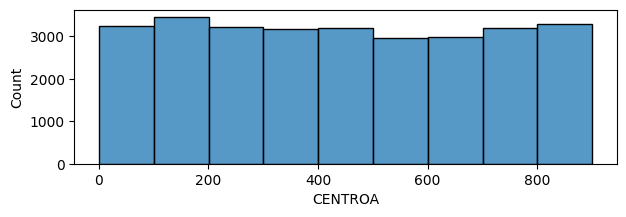

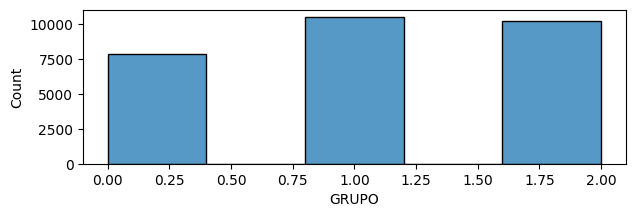

In [ ]:
plt.figure(figsize=(7, 2))
sns.histplot(data=dfBD1, x='CENTROA', bins=9)
plt.figure(figsize=(7, 2))
sns.histplot(data=dfBD1, x='GRUPO', bins=5)

Como ya esperaba, los colegios están numerados de 0 a 900 y en cada uno hay un máximo de tres grupos. Ello hace que el nuevo identificador de grupo (1000*CENTROA+GRUPO) será válido y no generará duplicados

In [ ]:
dfBD1['idGRUPO']=dfBD1['CENTROA']*1000+dfBD1['GRUPO']

In [ ]:
dfBD1.tail(5)

,CENTROA,GRUPO,ALUMNO,TITULAR,CUESTALU,P4A_lugar_nacimiento,P17_edad_escolarizacion,P18_repetidor,P24A,P24B,...,PV3mfis,PV4mfis,PV5mfis,PV1syc,PV2syc,PV3syc,PV4syc,PV5syc,calificaciones,idGRUPO
28703,900,2,19,1,1.0,4.0,3.0,1.0,4.0,4.0,...,504.847000,520.726233,483.060475,498.766176,442.987970,487.070886,448.222440,475.228601,20,900002
28704,900,2,20,1,1.0,4.0,1.0,1.0,4.0,4.0,...,372.180065,349.184110,384.914057,412.392223,373.130581,428.322560,447.289471,401.832757,20,900002
28705,900,2,21,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,900002
28706,900,2,22,1,1.0,4.0,3.0,2.0,4.0,2.0,...,469.253432,429.021324,500.316988,404.033453,422.496469,408.739784,450.088377,456.647375,20,900002
28707,900,2,24,1,1.0,4.0,2.0,1.0,4.0,2.0,...,445.524387,450.598950,424.819743,470.903611,416.907878,447.905335,463.149938,463.150804,20,900002


Tras comprobar en la última columna que funciona correctamente, elimino las dos primeras.

In [ ]:
dfBD1.drop(columns = ["CENTROA", "GRUPO"], inplace = True)

In [ ]:
for col in dfBD1.columns: print(col)

ALUMNO
TITULAR
CUESTALU
P4A_lugar_nacimiento
P17_edad_escolarizacion
P18_repetidor
P24A
P24B
P24C
P24D
P24E
P24F
P24G
P24H
P25A
P25B
P25C
P25D
P25E
P25F
P30A
P30B
P30C
P30D
P30E
PP02_edad
PP04_antigdad
PP05_en_centro
PP10_retutor
ISEC
PV1ling
PV2ling
PV3ling
PV4ling
PV5ling
PV1mat
PV2mat
PV3mat
PV4mat
PV5mat
PV1mfis
PV2mfis
PV3mfis
PV4mfis
PV5mfis
PV1syc
PV2syc
PV3syc
PV4syc
PV5syc
calificaciones
idGRUPO


(Compruebo que aparece al final el campo idGRUPO y que se han eliminado los dos iniciales)

Ahora se trata de separar el alumnado de un 80% y de un 20% aleatrorios de los grupos:

In [ ]:
# Lista con los grupos sin repeticiones
grupos = list(dfBD1['idGRUPO'].unique())
print(len(grupos))
random.seed(100) # Establezco una semilla para controlar los números aleatorios
# Selecciono aleatoriamente un 20% de los grupos para el conjunto de test
grupos_test = random.sample(grupos, round(len(grupos) * 0.2))
#
# Defino las bases de datos df_train y df_test
df_train = dfBD1.loc[~ (np.isin(dfBD1['idGRUPO'], grupos_test))].copy()
df_test =  dfBD1.loc[  (np.isin(dfBD1['idGRUPO'], grupos_test))].copy()
#
# Compruebo la cantidad de grupos de cada conjunto
print('Número de grupos de test:',   len(df_test['idGRUPO'].unique()),'(Porcentaje:', round(100 * len(df_test['idGRUPO'].unique()) / len(grupos),2), '%)')
print('Número de grupos de train:',  len(df_train['idGRUPO'].unique()),'(Porcentaje:', round(100 * len(df_train['idGRUPO'].unique()) / len(grupos),2), '%)')

1358
Número de grupos de test: 272 (Porcentaje: 20.03 %)
Número de grupos de train: 1086 (Porcentaje: 79.97 %)


In [ ]:
df_train.shape

(22828, 52)

(Efectivamente, en el conjunto de datos de entrenamiento, se mantiene el número de columnas pero se reduce el de registros al, aproximadamente, 80 %)

# **4. Preprocesado previo al cálculo del rendimiento**

## 4.1. Tratamiento de valores nulos y duplicados

### 4.1.1. Valores nulos

Para detectar valores nulos:

In [ ]:
for column in df_train.columns:
    num_nulls = df_train[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "ALUMNO" has 0 nulls
Column "TITULAR" has 0 nulls
Column "CUESTALU" has 672 nulls
Column "P4A_lugar_nacimiento" has 672 nulls
Column "P17_edad_escolarizacion" has 672 nulls
Column "P18_repetidor" has 672 nulls
Column "P24A" has 672 nulls
Column "P24B" has 672 nulls
Column "P24C" has 672 nulls
Column "P24D" has 672 nulls
Column "P24E" has 672 nulls
Column "P24F" has 672 nulls
Column "P24G" has 672 nulls
Column "P24H" has 672 nulls
Column "P25A" has 672 nulls
Column "P25B" has 672 nulls
Column "P25C" has 672 nulls
Column "P25D" has 672 nulls
Column "P25E" has 672 nulls
Column "P25F" has 672 nulls
Column "P30A" has 672 nulls
Column "P30B" has 672 nulls
Column "P30C" has 672 nulls
Column "P30D" has 672 nulls
Column "P30E" has 672 nulls
Column "PP02_edad" has 378 nulls
Column "PP04_antigdad" has 378 nulls
Column "PP05_en_centro" has 378 nulls
Column "PP10_retutor" has 378 nulls
Column "ISEC" has 0 nulls
Column "PV1ling" has 729 nulls
Column "PV2ling" has 729 nulls
Column "PV3ling" ha

Hay en torno a 700 alumnos que no hicieron los cuestionarios cuyas respuestas luego analizaremos.
Creo que lo más adecuado es eliminarlos del análisis.

In [ ]:
df_train.dropna(subset=['CUESTALU'],inplace=True)

Vuelvo a comprobar

In [ ]:
for column in df_train.columns:
    num_nulls = df_train[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "ALUMNO" has 0 nulls
Column "TITULAR" has 0 nulls
Column "CUESTALU" has 0 nulls
Column "P4A_lugar_nacimiento" has 0 nulls
Column "P17_edad_escolarizacion" has 0 nulls
Column "P18_repetidor" has 0 nulls
Column "P24A" has 0 nulls
Column "P24B" has 0 nulls
Column "P24C" has 0 nulls
Column "P24D" has 0 nulls
Column "P24E" has 0 nulls
Column "P24F" has 0 nulls
Column "P24G" has 0 nulls
Column "P24H" has 0 nulls
Column "P25A" has 0 nulls
Column "P25B" has 0 nulls
Column "P25C" has 0 nulls
Column "P25D" has 0 nulls
Column "P25E" has 0 nulls
Column "P25F" has 0 nulls
Column "P30A" has 0 nulls
Column "P30B" has 0 nulls
Column "P30C" has 0 nulls
Column "P30D" has 0 nulls
Column "P30E" has 0 nulls
Column "PP02_edad" has 368 nulls
Column "PP04_antigdad" has 368 nulls
Column "PP05_en_centro" has 368 nulls
Column "PP10_retutor" has 368 nulls
Column "ISEC" has 0 nulls
Column "PV1ling" has 251 nulls
Column "PV2ling" has 251 nulls
Column "PV3ling" has 251 nulls
Column "PV4ling" has 251 nulls
Col

Por un lado, me fijo en que ya no hay ningún valor nulo entre las 19 variables correpondientes a los datos sobre las prácticas del profesorado (importante para la segunda fase del trabajo)
Por otro, pienso que también es preferible eliminar del database a aquellos alumnos con menos de la mitad de las 20 calificaciones. ¿O quizás a los que no tengan las 20? Voy a comprobar primero si son muchos

[48, 0, 0, 0, 0, 21, 0, 0, 0, 0, 451, 0, 0, 0, 0, 436, 0, 0, 0, 0, 21200]


<BarContainer object of 21 artists>

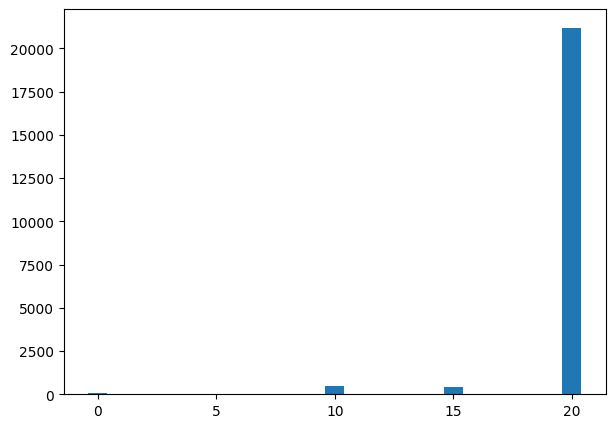

In [ ]:
plt.figure(figsize=(7, 5))
y = [sum(df_train['calificaciones'] == i) for i in range(21)]
print(y)
plt.bar(range(21), y)

Inicialmente opté por eliminar las solo decenas de alumnos con menos de 10 calificaciones y conservar el resto, pensando que, para aquellos alumnos con 10 o 15 de las calificaciones, como todas ellas están normalizadas a una N(500,100), la nota media de todas las calificaciones de cada alumno seguiría siendo perfectamente válida.
Posteriormente pude observar que, como las correlaciones entre las cuatro asignaturas no son lo altas que yo esperaba, esa media calculada con no todas las asignaturas podría no ser representativa.
Concluyendo: elimino los datos correspondientes a los alumnos sin las 20 calificaciones completas.

In [ ]:
df_train = df_train.loc[df_train['calificaciones']== 20]
y = pd.Series([sum(df_train['calificaciones'] == i) for i in range(21)], index = range(21))
print(y)

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20    21200
dtype: int64


### 4.1.2. Tratamiento de valores duplicados

Confío en que no va a haber valores repetidos en el dataframe. Pero lo compruebo con el método duplicated().

In [ ]:
df_train[df_train.duplicated(keep=False)]

,ALUMNO,TITULAR,CUESTALU,P4A_lugar_nacimiento,P17_edad_escolarizacion,P18_repetidor,P24A,P24B,P24C,P24D,...,PV3mfis,PV4mfis,PV5mfis,PV1syc,PV2syc,PV3syc,PV4syc,PV5syc,calificaciones,idGRUPO


Comprobamos que en el conjunto de test tampoco existen duplicados:

In [ ]:
df_test[df_test.duplicated(keep=False)]

,ALUMNO,TITULAR,CUESTALU,P4A_lugar_nacimiento,P17_edad_escolarizacion,P18_repetidor,P24A,P24B,P24C,P24D,...,PV3mfis,PV4mfis,PV5mfis,PV1syc,PV2syc,PV3syc,PV4syc,PV5syc,calificaciones,idGRUPO


## 4.2. Cálculo de la nota media

Antes de sustituir las 20 columnas correspondientes a las calificaciones de cada alumno por su promedio, voy a comprobar que no hay ningún outlier en ellas. De paso, entraré en parte del ...

### 4.2.1. Análisis univariante de las notas

In [ ]:
lista_asignaturas = {'ling':[], 'mat':[], 'mfis':[], 'syc':[]}

for col in df_train.columns:
  if col[:2] == 'PV':
    asignatura = col[3:]
    lista_asignaturas[asignatura].append(col)
lista_asignaturas

{'ling': ['PV1ling', 'PV2ling', 'PV3ling', 'PV4ling', 'PV5ling'],
 'mat': ['PV1mat', 'PV2mat', 'PV3mat', 'PV4mat', 'PV5mat'],
 'mfis': ['PV1mfis', 'PV2mfis', 'PV3mfis', 'PV4mfis', 'PV5mfis'],
 'syc': ['PV1syc', 'PV2syc', 'PV3syc', 'PV4syc', 'PV5syc']}

Tras crear una lista con los nombres de cada una de las 20 pruebas (de cuatro asignaturas), compruebo que los valores mínimo y máximo en cada prueba son coherentes con una distribución normal de media 500 y desviación típica 100 (que es lo que se explica en la documentación de la base de datos)

In [ ]:
dict_summary = {'pregunta':[], 'min':[],'max':[]}
for asignatura in lista_asignaturas:
  for pregunta in lista_asignaturas[asignatura]:
    dict_summary['pregunta'].append(pregunta)
    dict_summary['min'].append(df_train[pregunta].min())
    dict_summary['max'].append(df_train[pregunta].max())
pd.DataFrame(dict_summary)


,pregunta,min,max
0,PV1ling,136.805450,853.215573
1,PV2ling,139.368527,850.145943
2,PV3ling,138.032054,851.473731
3,PV4ling,137.715329,851.661001
4,PV5ling,138.203135,850.865561
5,PV1mat,136.949992,851.692837
6,PV2mat,137.011383,853.311191
7,PV3mat,136.577055,851.203969
8,PV4mat,135.348915,852.801467
9,PV5mat,133.872807,853.760731


Veamos también los correspondientes 20 histogramas

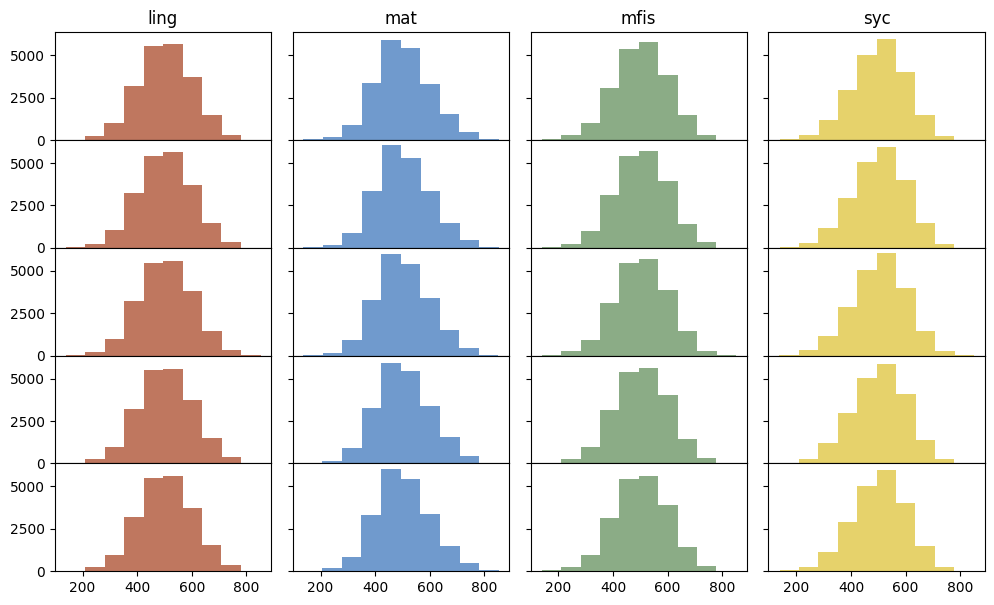

In [ ]:
colores =  {'ling':'#bf775f', 'mat':'#709acd', 'mfis':'#8bac86', 'syc':'#e6d26b'}

fig, axes = plt.subplots(figsize= (12, 7), ncols = 4,nrows = 5, gridspec_kw={'hspace':0, 'wspace':0.1}, sharex = True, sharey = True)
for i in range(4):
  asignatura = list(lista_asignaturas.keys())[i]
  lista_col = lista_asignaturas[asignatura]
  lista_valores = [df_train.loc[~df_train[col].isna(), col] for col in lista_col]
  for j in range(5):
    axes[j,i].hist(lista_valores[j], color = colores[asignatura])
  axes[0,i].set_title(asignatura)


A la vista de los histogramas y de los valores mínimos y máximos, considero que no hay valores erróneos ni outliers. Dicho de otro modo, aunque existan valores alejados de la media, sería un error eliminarlos pues lo que estaríamos haciendo sería dejar de tener en cuenta a los mejores y peores alumnos

### 4.2.2 Análisis multivariante y de correlación

In [ ]:
# En una lista incluyo las 20 preguntas (o bien calificaciones)
lista_preguntas = []
for asignatura in lista_asignaturas:
  lista_preguntas.extend(lista_asignaturas[asignatura])
print(lista_preguntas)

['PV1ling', 'PV2ling', 'PV3ling', 'PV4ling', 'PV5ling', 'PV1mat', 'PV2mat', 'PV3mat', 'PV4mat', 'PV5mat', 'PV1mfis', 'PV2mfis', 'PV3mfis', 'PV4mfis', 'PV5mfis', 'PV1syc', 'PV2syc', 'PV3syc', 'PV4syc', 'PV5syc']


In [ ]:
# Correlaciones entre cada par de calificaciones
corr = df_train[lista_preguntas].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')
 .format(precision=2))

,PV1ling,PV2ling,PV3ling,PV4ling,PV5ling,PV1mat,PV2mat,PV3mat,PV4mat,PV5mat,PV1mfis,PV2mfis,PV3mfis,PV4mfis,PV5mfis,PV1syc,PV2syc,PV3syc,PV4syc,PV5syc
PV1ling,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV2ling,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV3ling,0.86,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV4ling,0.86,0.86,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV5ling,0.86,0.86,0.86,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV1mat,0.53,0.53,0.54,0.53,0.53,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV2mat,0.54,0.54,0.54,0.54,0.54,0.80,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV3mat,0.54,0.54,0.54,0.54,0.54,0.80,0.81,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV4mat,0.54,0.54,0.54,0.54,0.54,0.80,0.81,0.80,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PV5mat,0.53,0.54,0.54,0.54,0.54,0.81,0.80,0.81,0.80,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Es fácilmente observable que las correlaciones correspondientes a pares de preguntas de la misma asignatura son mucho más altas (mayores que 0.8) que las correspondientes a asignaturas diferentes (entre 0.5 y 0.6). Parece lógico, aunque yo esperaba que estas últimas fueran mayores.

Vamos ahora a sustituir, para cada alumno, sus 20 calificaciones por el promedio de las mismas.
Primero crearé una nueva columna con esa nota media.
También aprovecho para graficar los valores de esa nueva columna que, lógicamente darán una distribución cerca de la normal de media próxima a 500 y desviación típica probablemente menor que 100

### 4.2.3 Cálculo de la nota media y descripción de ésta

(array([   0.,    0.,    0.,    0.,    9.,   47.,  427., 1700., 3412.,
        4635., 4754., 3679., 1994.,  516.,   27.,    0.,    0.,    0.,
           0.,    0.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]),
 <BarContainer object of 20 artists>)

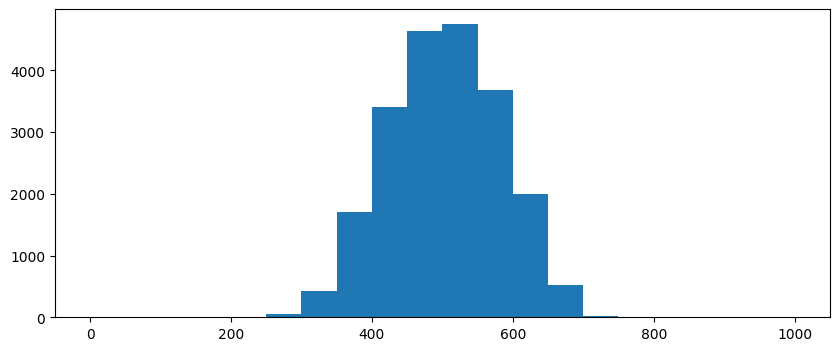

In [ ]:
# Creo la columna de la media asignándole inicialmente el valor 0 y luego sumándole el valor de cada una de las calificaciones
df_train['PVmedia'] = 0
for pregunta in lista_preguntas:
  df_train['PVmedia'] += df_train[pregunta]
df_train['PVmedia'] = df_train['PVmedia'] / df_train['calificaciones']

fig, ax = plt.subplots(figsize = (10,4))
ax.hist(df_train['PVmedia'], bins = np.array(range(21))* 50)

Borro ya las 20+2 columnas que ya no aportan nada

In [ ]:
df_train.drop(lista_preguntas + ['calificaciones', 'CUESTALU'],inplace=True, axis = 1)
df_train.columns

Index(['ALUMNO', 'TITULAR', 'P4A_lugar_nacimiento', 'P17_edad_escolarizacion',
       'P18_repetidor', 'P24A', 'P24B', 'P24C', 'P24D', 'P24E', 'P24F', 'P24G',
       'P24H', 'P25A', 'P25B', 'P25C', 'P25D', 'P25E', 'P25F', 'P30A', 'P30B',
       'P30C', 'P30D', 'P30E', 'PP02_edad', 'PP04_antigdad', 'PP05_en_centro',
       'PP10_retutor', 'ISEC', 'idGRUPO', 'PVmedia'],
      dtype='object')

## 4.3 Análisis de la relación entre la nota media y las variables de contexto

### 4.3.1. Preprocesado de las variables de contexto

Entre las columnas que nos quedan, además del ISEC, hay otras tres variables "de contexto del alumnado" con las que interesa analizar su posible correlación con los resultados (o PVmedia).
Se trata de 'P17_edad_escolarizacion', 'P18_repetidor' y 'P4A_lugar_nacimiento'.
Pero antes, vamos a transformar esta última para que solo diferencie entre dos categorías (alumnado nacido en España y nacido en el extranjero) y algo análogo con la P18 (alumnado que consta como repetidor y que no)

In [ ]:
df_train['Extranjero'] = 0
df_train.loc[df_train['P4A_lugar_nacimiento']>18 , 'Extranjero'] = 1
df_train['Repetidor'] = 0
df_train.loc[np.isin(df_train['P18_repetidor'], [2,3]) , 'Repetidor'] = 1

### 4.3.2. Análisis de correlación lineal

In [ ]:
# Nuevas correlaciones entre el promedio de las calificaciones y cada una de las tres variables de contexto del alumnado
corr = df_train[['PVmedia','ISEC','Extranjero',  'P17_edad_escolarizacion', 'Repetidor']].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,PVmedia,ISEC,Extranjero,P17_edad_escolarizacion,Repetidor
PVmedia,nan,nan,nan,nan,nan
ISEC,0.40,nan,nan,nan,nan
Extranjero,-0.13,-0.16,nan,nan,nan
P17_edad_escolarizacion,-0.19,-0.18,0.20,nan,nan
Repetidor,-0.22,-0.19,0.10,0.07,nan


Visualizo las correlaciones entre la Nota Media y las cuatro variables de contexto del alumno disponibles.
Yo esperaba una mayor correlación con el ISEC. De todos modos, como de lo que se trata luego es de eliminar la posible influencia del ISEC y el resto de variables en las calificaciones, la moderación de esa correlación no supone mayor problema para mi trabajo.
Lo siguiente va a ser visualizar los mismo datos como nubes de puntos

Text(0.5, 0, 'ISEC')

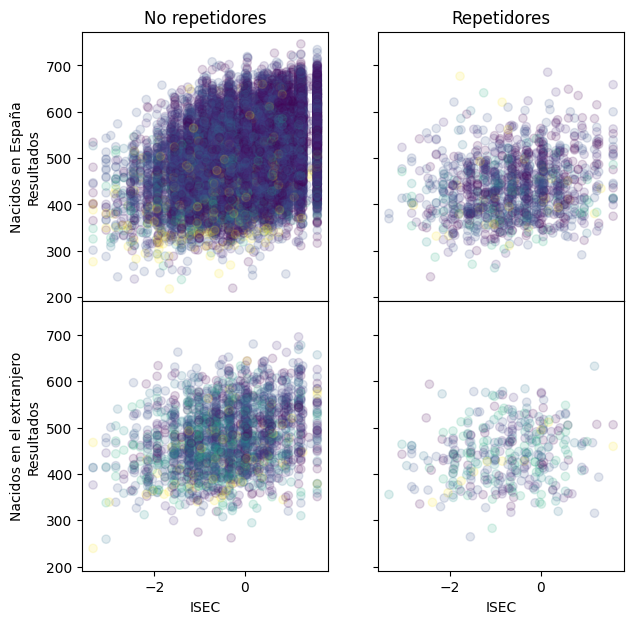

In [ ]:
fig, ax = plt.subplots(figsize = (7,7), ncols = 2, nrows = 2, sharex = True,sharey = True, gridspec_kw = {'hspace':0})

df_00 = df_train.loc[(df_train['Extranjero'] == 0) & (df_train['Repetidor'] == 0)]
df_01 = df_train.loc[(df_train['Extranjero'] == 0) & (df_train['Repetidor'] == 1)]
df_10 = df_train.loc[(df_train['Extranjero'] == 1) & (df_train['Repetidor'] == 0)]
df_11 = df_train.loc[(df_train['Extranjero'] == 1) & (df_train['Repetidor'] == 1)]
#
#
ax[0,0].scatter(df_00['ISEC'], df_00['PVmedia'], alpha = 0.15, c = df_00['P17_edad_escolarizacion'])
ax[0,1].scatter(df_01['ISEC'], df_01['PVmedia'], alpha = 0.15, c = df_01['P17_edad_escolarizacion'])
ax[1,0].scatter(df_10['ISEC'], df_10['PVmedia'], alpha = 0.15, c = df_10['P17_edad_escolarizacion'])
ax[1,1].scatter(df_11['ISEC'], df_11['PVmedia'], alpha = 0.15, c = df_11['P17_edad_escolarizacion'])
ax[0,0].set_ylabel('Nacidos en España\nResultados')
ax[1,0].set_ylabel('Nacidos en el extranjero\nResultados')
ax[0,0].set_title('No repetidores')
ax[0,1].set_title('Repetidores')
ax[1,0].set_xlabel('ISEC')
ax[1,1].set_xlabel('ISEC')


En las anteriores nubes de puntos, se puede observar esa moderada correlación del ISEC con los resultados o notas medias del alumnado. Las dos nubes superiores corresponden al alumnado nacido en España y las inferiores al nacido en el extranjero. A la izquierda se visualiza el alumnado no repetidor y a la derecha, el repetidor. Y el color atiende a la edad de escolarización.

Me sorprenden un poco los valores del ISEC (que por la derecha se cortan de un modo menos progresivo que por la izquierda). Por eso, saco el correspondiente histograma.

<Axes: xlabel='ISEC', ylabel='Count'>

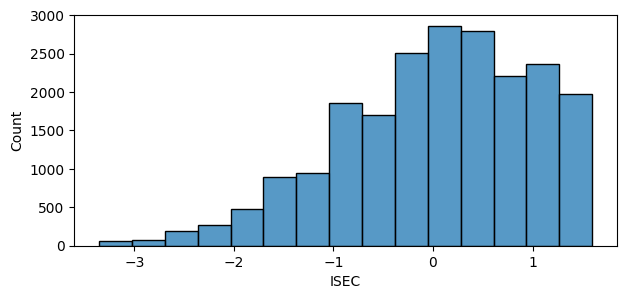

In [ ]:
plt.figure(figsize=(7, 3))
sns.histplot(data=df_train, x='ISEC', bins=15)

Queda confirmado que las nubes de puntos se corresponden con los datos: al parecer, el ISEC tiene una distribución no simétrica

# **5.  Cálculo del rendimiento para cada alumno**

Siguiendo el plan previsto, ahora toca calcular para cada alumno-a, cuál sería su nota media "esperada" según su ISEC y sus cuatro variables de contexto, para luego definir el "rendimiento" de cada alumno como la diferencia entere la nota obtenida y la esperada.

Como se puede observar, por un lado, la correlación lineal no es lo suficientemente alta y por el otro, en las gráficas de puntos no se observa una relación lineal lo suficientemente fuerte. Además, con la excepción del ISEC, el resto de variables son o cualitativas o numéricas pero discretas.

Por estas razones, es más conveniente utilizar un modelo no paramétrico, como es el caso del modelo **Random Forest**, en vez de un modelo de regresión lineal.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
modelo = RandomForestRegressor(
            n_estimators = 4,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
variables_pred = ['ISEC','Extranjero',  'P17_edad_escolarizacion', 'Repetidor']
modelo.fit(df_train[variables_pred], df_train['PVmedia'])

RandomForestRegressor(max_features=1, n_estimators=4, n_jobs=-1,
                      random_state=123)

Tras crear y entrenar el modelo de Random Forest Regressor, definimos la nota esperada a partir de las predicciones del mismo. También calculamos la nueva variable de rendimiento.


In [ ]:
# Calculamos las predicciones
df_train['Predicciones'] = pd.Series(modelo.predict(X = df_train[variables_pred]), index = df_train.index)
# Calculamos el rendimiento como la diferencia entre el valor real de la media y las predicciones
df_train['Rendimiento'] = df_train['PVmedia'] -  df_train['Predicciones']
# Visualizamos algunos ejemplos
df_train[['PVmedia','Predicciones','Rendimiento' ]].head(10)

,PVmedia,Predicciones,Rendimiento
0,484.473955,509.681379,-25.207424
1,592.169070,537.223166,54.945904
2,450.540920,536.446675,-85.905755
3,555.927488,550.654479,5.273009
4,525.272789,549.593501,-24.320712
5,567.497855,514.860177,52.637678
6,432.627594,499.805958,-67.178364
7,481.158380,448.292695,32.865685
8,490.732824,511.562868,-20.830044
9,467.100512,456.311582,10.788930


Como se observa, en los casos en los que el rendimiento es positivo la media es mayor a la predicción (o nota "esperada"), mientras que, en los casos en los que es negativo, la nota media es menor a la nota esperada por su contexto.

<Axes: xlabel='Rendimiento', ylabel='Count'>

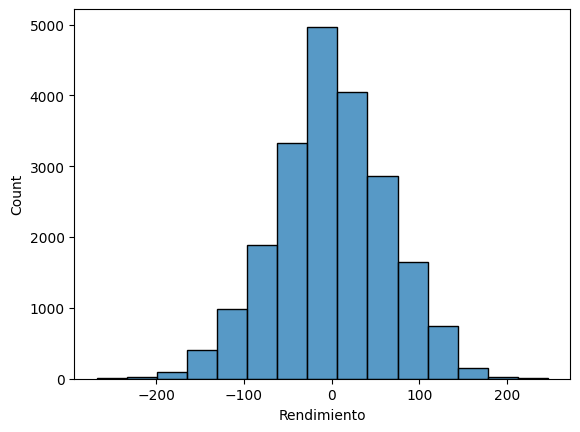

In [ ]:
sns.histplot(data=df_train, x='Rendimiento', bins=15)

Como puede observarse, y era de esperar, la nueva variable "Rendimiento" sigue una distribución normal de media prácticamente 0.

El objetivo de la aplicación de este modelo, no es tanto el conseguir unos resultados afinados de la nota media sino quitarle a dicha nota la influencia que puedan tener las variables de contexto de cada alumno. En la siguiente gráfica comprobamos si la correlación entre cada variable de contexto y el rendimiento son nulas.

In [ ]:
# Nuevas correlaciones entre el promedio de las calificaciones y cada una de las tres variables de contexto del alumnado
corr = df_train[['Rendimiento','ISEC','Extranjero',  'P17_edad_escolarizacion', 'Repetidor']].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,Rendimiento,ISEC,Extranjero,P17_edad_escolarizacion,Repetidor
Rendimiento,nan,nan,nan,nan,nan
ISEC,-0.00,nan,nan,nan,nan
Extranjero,-0.00,-0.16,nan,nan,nan
P17_edad_escolarizacion,-0.00,-0.18,0.20,nan,nan
Repetidor,-0.00,-0.19,0.10,0.07,nan


Efectivamente, la correlación entre el rendimiento y cada variable de contexto es nula. Eso significa que se ha **conseguido el objetivo** citado anteriormente para la base de datos de entrenamiento. Posteriormente tendremos que comprobar lo mismo para la base de datos de testeo.

# **6. Transformación de los datos: Creación de la nueva tabla**

Para finalizar la primera fase del trabajo, hay que transformar los datos de la tabla actual, con un registro por cada alumno, a otra con solo un registro por grupo o profesor-a/tutor-a.

Antes, conviene aclarar que cada alumno respondió a 19 cuestiones relativas a las prácticas docentes de su profesorado (como, por ejemplo, "Trabajamos en grupos") con respuestas cualitativas pero progresivas:
- Nunca o casi nunca (repuesta registrada con un 1)
- Algunas veces (con un 2)
- Casi siempre (con un 3)
- Siempre (con un 4)
Ello hace que tenga sentido el cálculo del promedio de esas respuestas del alumnado de cada grupo, lo que dará un valor significativo para ese grupo o su tutor-a.
No olvidar que si el alumno-a no contestó a una de esas preguntas, ello se registró con un 9. (Lo que se tendrá en cuenta para el cálculo de los promedios citados)
Vamos a ello:

Para cada grupo de alumnos hemos de:
*   Conservar su identificador (idGRUPO)
*   Para cada una de las 19 variables acerca de las prácticas del profesorado (desde P24A a P30E), para cada grupo, se calcula el promedio de las correspondientes respuestas del alumnado de ese grupo)
*   Y para el Rendimiento medio de cada grupo







In [ ]:
columnas_cuestionario = ['P24A', 'P24B', 'P24C', 'P24D', 'P24E', 'P24F', 'P24G',
       'P24H', 'P25A', 'P25B', 'P25C', 'P25D', 'P25E', 'P25F', 'P30A', 'P30B',
       'P30C', 'P30D', 'P30E']
#
# Inicializo la estructura en la que voy a ir guardando los valores
dict_aux = {'id_grupo':[], 'Rendimiento':[]}
for col in columnas_cuestionario: dict_aux[col] = []
#
#
grupos_train = df_train['idGRUPO'].unique()
for id in grupos_train:
  for col in columnas_cuestionario:
    id_col = df_train.loc[df_train['idGRUPO'] == id, col]
    m = id_col.loc[np.isin(id_col, [1,2,3,4])].mean()
    dict_aux[col].append(m)
  id_rend = df_train.loc[df_train['idGRUPO'] == id, 'Rendimiento']
  m = id_rend.mean()
  dict_aux['Rendimiento'].append(m)
  dict_aux['id_grupo'].append(id)
df_tabla_train = pd.DataFrame(dict_aux)
df_tabla_train.head()


,id_grupo,Rendimiento,P24A,P24B,P24C,P24D,P24E,P24F,P24G,P24H,...,P25B,P25C,P25D,P25E,P25F,P30A,P30B,P30C,P30D,P30E
0,1000,13.040048,3.055556,2.444444,3.055556,3.235294,2.222222,3.388889,3.222222,1.764706,...,2.333333,1.888889,1.222222,2.000000,1.882353,2.111111,2.277778,2.333333,2.555556,2.250000
1,2001,58.553678,2.650000,2.450000,2.000000,3.050000,1.550000,3.800000,3.350000,2.150000,...,1.900000,2.450000,1.500000,2.200000,1.800000,1.850000,2.300000,2.400000,2.350000,2.550000
2,2002,33.281990,2.800000,2.720000,2.520000,3.320000,1.960000,3.520000,3.120000,2.083333,...,2.000000,2.240000,1.360000,1.833333,2.000000,2.160000,2.640000,2.280000,2.560000,2.440000
3,3000,22.880696,2.958333,2.333333,2.500000,2.750000,1.791667,3.666667,2.782609,2.652174,...,2.125000,2.500000,1.750000,2.363636,1.782609,1.782609,2.173913,2.000000,2.608696,2.500000
4,4000,-64.556692,3.666667,2.454545,3.166667,2.300000,1.833333,3.333333,2.833333,2.250000,...,1.900000,1.700000,1.600000,2.300000,2.700000,2.555556,2.555556,2.444444,2.666667,2.555556


In [ ]:
df_tabla_train.index = df_tabla_train['id_grupo']

*   Tanto con la Titularidad del centro, como con las variables de datos del
profesorado (edad,antigüedad...) es suficiente con tomar el valor del primer registro/alumno del grupo


In [ ]:
df_train.columns

Index(['ALUMNO', 'TITULAR', 'P4A_lugar_nacimiento', 'P17_edad_escolarizacion',
       'P18_repetidor', 'P24A', 'P24B', 'P24C', 'P24D', 'P24E', 'P24F', 'P24G',
       'P24H', 'P25A', 'P25B', 'P25C', 'P25D', 'P25E', 'P25F', 'P30A', 'P30B',
       'P30C', 'P30D', 'P30E', 'PP02_edad', 'PP04_antigdad', 'PP05_en_centro',
       'PP10_retutor', 'ISEC', 'idGRUPO', 'PVmedia', 'Extranjero', 'Repetidor',
       'Predicciones', 'Rendimiento'],
      dtype='object')

In [ ]:
df_aux = df_train.drop_duplicates('idGRUPO')
df_aux.index = df_aux['idGRUPO']
for col in ['TITULAR', 'PP02_edad', 'PP04_antigdad', 'PP05_en_centro',
       'PP10_retutor']:
       df_aux
       df_tabla_train[col] = df_aux[col]

In [ ]:
df_tabla_train

,id_grupo,Rendimiento,P24A,P24B,P24C,P24D,P24E,P24F,P24G,P24H,...,P30A,P30B,P30C,P30D,P30E,TITULAR,PP02_edad,PP04_antigdad,PP05_en_centro,PP10_retutor
id_grupo,,,,,,,,,,,,,,,,,,,,,
1000,1000,13.040048,3.055556,2.444444,3.055556,3.235294,2.222222,3.388889,3.222222,1.764706,...,2.111111,2.277778,2.333333,2.555556,2.250000,2,2.0,2.0,2.0,2.0
2001,2001,58.553678,2.650000,2.450000,2.000000,3.050000,1.550000,3.800000,3.350000,2.150000,...,1.850000,2.300000,2.400000,2.350000,2.550000,2,3.0,6.0,1.0,2.0
2002,2002,33.281990,2.800000,2.720000,2.520000,3.320000,1.960000,3.520000,3.120000,2.083333,...,2.160000,2.640000,2.280000,2.560000,2.440000,2,1.0,1.0,1.0,1.0
3000,3000,22.880696,2.958333,2.333333,2.500000,2.750000,1.791667,3.666667,2.782609,2.652174,...,1.782609,2.173913,2.000000,2.608696,2.500000,1,3.0,5.0,5.0,1.0
4000,4000,-64.556692,3.666667,2.454545,3.166667,2.300000,1.833333,3.333333,2.833333,2.250000,...,2.555556,2.555556,2.444444,2.666667,2.555556,1,2.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897000,897000,-36.232186,3.153846,2.846154,2.916667,2.923077,1.615385,3.181818,2.846154,1.833333,...,1.909091,2.230769,2.250000,2.666667,2.545455,1,3.0,3.0,1.0,2.0
898000,898000,2.090488,2.888889,2.944444,2.666667,2.764706,1.555556,3.666667,3.166667,1.611111,...,1.888889,2.333333,2.111111,2.235294,2.388889,1,5.0,7.0,7.0,2.0
899000,899000,9.492580,3.166667,2.666667,3.500000,3.916667,2.083333,3.666667,3.416667,2.000000,...,1.916667,2.500000,2.416667,2.166667,2.666667,1,3.0,6.0,1.0,2.0


Y hasta aquí la creación de la nueva tabla con un registro por grupo.

# **7. Valores nulos (en la nueva tabla)**

Por lo visto en la database original, hay unos pocos profesores/tutores que no hicieron el correspondiente cuestionario, de modo que las variables 'PP02_edad', 'PP04_antigdad', 'PP05_en_centro', 'PP10_retutor' contienen un '9' cuyo significado es que no hay respuesta a la pregunta.

In [ ]:
columnas = ['PP02_edad','PP04_antigdad', 'PP05_en_centro', 'PP10_retutor']
numero_nas = pd.Series([sum((df_tabla_train[col] == 9) | df_tabla_train[col].isna())   for col in columnas], index = columnas)
numero_nas

PP02_edad         17
PP04_antigdad     17
PP05_en_centro    17
PP10_retutor      17
dtype: int64

Son pocos de manera que su borrado no va a suponer una pérdida significativa de datos.

In [ ]:
len(df_tabla_train)

1086

In [ ]:
for col in columnas:
  df_tabla_train.drop(df_tabla_train.loc[(df_tabla_train[col] == 9) | (df_tabla_train[col].isna()) ].index, inplace = True)

In [ ]:
len(df_tabla_train)

1044

Una vez hemos eliminado los grupos en los que el profesor no había respondido a una de las preguntas comprobamos que sólo hemos perdido unas pocas decenas registros de los más de 1000 iniciales.

# **8. Análisis descriptivo de la database final**

# 8.1. Análisis univariante

### 8.1.1.Variables categóricas

Text(0.5, 1.0, 'Titularidad del centro')

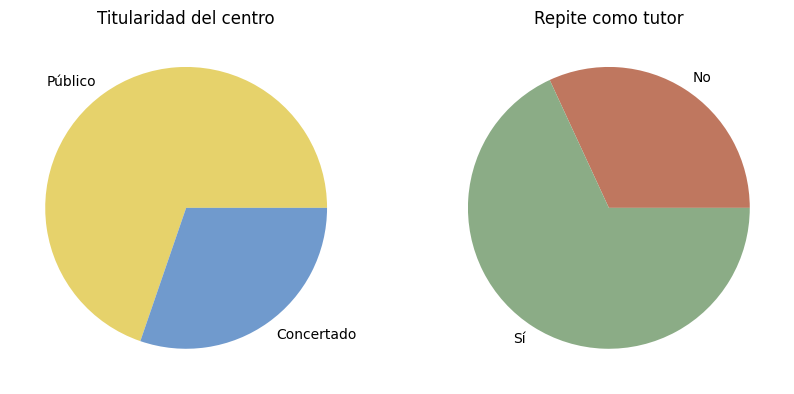

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5), ncols = 2)
ax[0].pie([sum(df_tabla_train['TITULAR']== i) for i in [1, 2]], labels = ['Público','Concertado'], colors = ['#e6d26b','#709acd'])
ax[1].pie([sum(df_tabla_train['PP10_retutor']== i) for i in [1, 2]], labels = ['No', 'Sí'], colors = ['#bf775f', '#8bac86'])
ax[1].set_title('Repite como tutor')
ax[0].set_title('Titularidad del centro')


Como se puede observar, hay mayoría de centros públicos y de profesores que repiten como tutor en el grupo

### 8.1.2.Variables referidas al profesorado y sus colegios

In [ ]:
df_tabla_train.columns


Index(['id_grupo', 'Rendimiento', 'P24A', 'P24B', 'P24C', 'P24D', 'P24E',
       'P24F', 'P24G', 'P24H', 'P25A', 'P25B', 'P25C', 'P25D', 'P25E', 'P25F',
       'P30A', 'P30B', 'P30C', 'P30D', 'P30E', 'TITULAR', 'PP02_edad',
       'PP04_antigdad', 'PP05_en_centro', 'PP10_retutor'],
      dtype='object')

In [ ]:
df_tabla_train['PP05_en_centro'].unique()

array([2., 1., 5., 7., 3., 4., 6.])

Text(0.5, 1.0, 'Antigüedad en el centro')

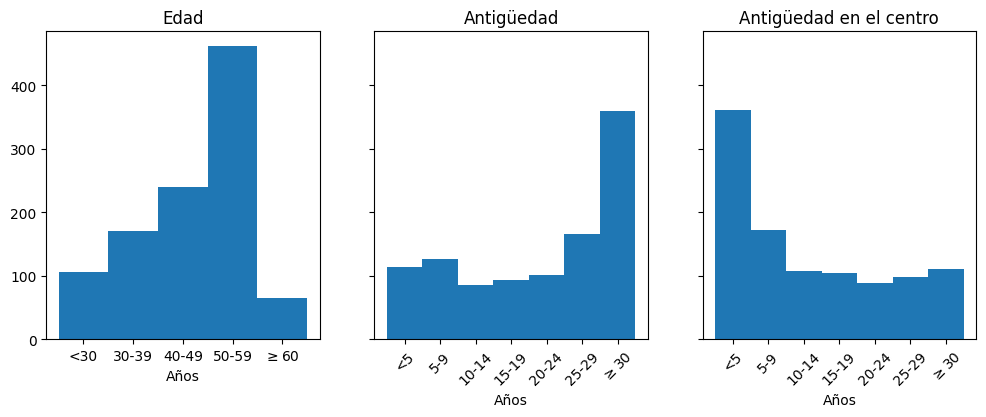

In [ ]:

fig, ax = plt.subplots(figsize = (12, 4), ncols = 3, sharey = True)
#
# Edad
valores = [sum(df_tabla_train['PP02_edad'] == i) for i in range(1, 6)]
ax[0].bar(range(1,6), valores, width = 1)
ax[0].set_xticks(range(1,6),['<30','30-39','40-49','50-59', '$\geq 60$'])
ax[0].set_xlabel('Años')
ax[0].set_title('Edad')
#
# Antigüedad
valores = [sum(df_tabla_train['PP04_antigdad'] == i) for i in range(1, 8)]
ax[1].bar(range(1,8), valores, width = 1)
ax[1].set_xticks(range(1,8),['<5','5-9','10-14','15-19', '20-24', '25-29', '$\geq 30$'], rotation = 45)
ax[1].set_xlabel('Años')
ax[1].set_title('Antigüedad')
#
# Antigüedad en el centro
valores = [sum(df_tabla_train['PP05_en_centro'] == i) for i in range(1, 8)]
ax[2].bar(range(1,8), valores, width = 1)
ax[2].set_xticks(range(1,8),['<5','5-9','10-14','15-19', '20-24', '25-29', '$\geq 30$'], rotation = 45)
ax[2].set_xlabel('Años')
ax[2].set_title('Antigüedad en el centro')

Aquí se puede observar cómo la edad y antigüedad del profesorado son bastante elevadas pero no así la antigüedad en el centro.

### 8.1.3. Cuestiones pedagógicas

Vamos con las cuestiones acerca del **Trabajo en clase con el profesorado**:


Text(0.5, 1.0, '(P24H)\nTrabajamos\nen pequeños grupos')

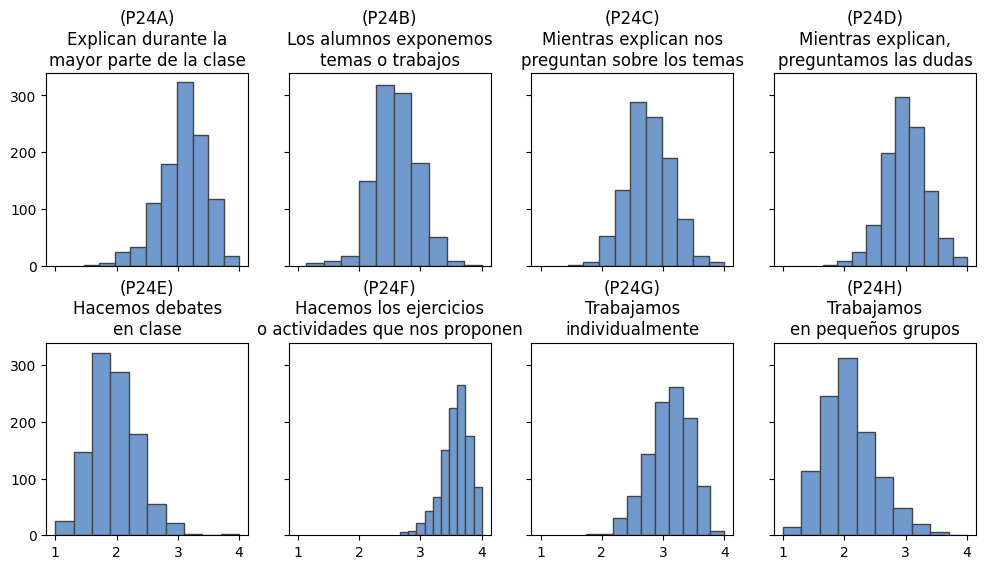

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6), ncols = 4, nrows = 2, sharey = True, sharex = True, gridspec_kw = {'hspace': 0.4})

ax[0,0].hist(df_tabla_train['P24A'], color ='#709acd' ,edgecolor = '#444444')
ax[0,1].hist(df_tabla_train['P24B'], color ='#709acd' ,edgecolor = '#444444')
ax[0,2].hist(df_tabla_train['P24C'], color ='#709acd' ,edgecolor = '#444444')
ax[0,3].hist(df_tabla_train['P24D'], color ='#709acd' ,edgecolor = '#444444')
ax[1,0].hist(df_tabla_train['P24E'], color ='#709acd' ,edgecolor = '#444444')
ax[1,1].hist(df_tabla_train['P24F'], color ='#709acd' ,edgecolor = '#444444')
ax[1,2].hist(df_tabla_train['P24G'], color ='#709acd' ,edgecolor = '#444444')
ax[1,3].hist(df_tabla_train['P24H'], color ='#709acd' ,edgecolor = '#444444')

ax[0,0].set_title('(P24A)\nExplican durante la\nmayor parte de la clase'          )
ax[0,1].set_title('(P24B)\nLos alumnos exponemos\ntemas o trabajos'               )
ax[0,2].set_title('(P24C)\nMientras explican nos\npreguntan sobre los temas'      )
ax[0,3].set_title('(P24D)\nMientras explican,\npreguntamos las dudas'             )
ax[1,0].set_title('(P24E)\nHacemos debates\nen clase'                             )
ax[1,1].set_title('(P24F)\nHacemos los ejercicios\no actividades que nos proponen')
ax[1,2].set_title('(P24G)\nTrabajamos\nindividualmente'                           )
ax[1,3].set_title('(P24H)\nTrabajamos\nen pequeños grupos'                        )










La escala del 1 al 4 se corresponde con la progresión siguiente:

1:	Nunca o casi nunca

2:	Algunas veces

3:	Casi siempre

4:	Siempre


Se puede observar cómo:

Que el profesor explique es más frecuente que que el alumnado exponga.

Que se hagan los ejercicios es muy frecuente, pero los debates en clase no.

O que se trabaja más individualmente que en grupo.

Vamos con algo análogo para la **Utilización materiales en clase**

Text(0.5, 1.0, '(P25F)\nMedios audiovisuales,videos, DVD')

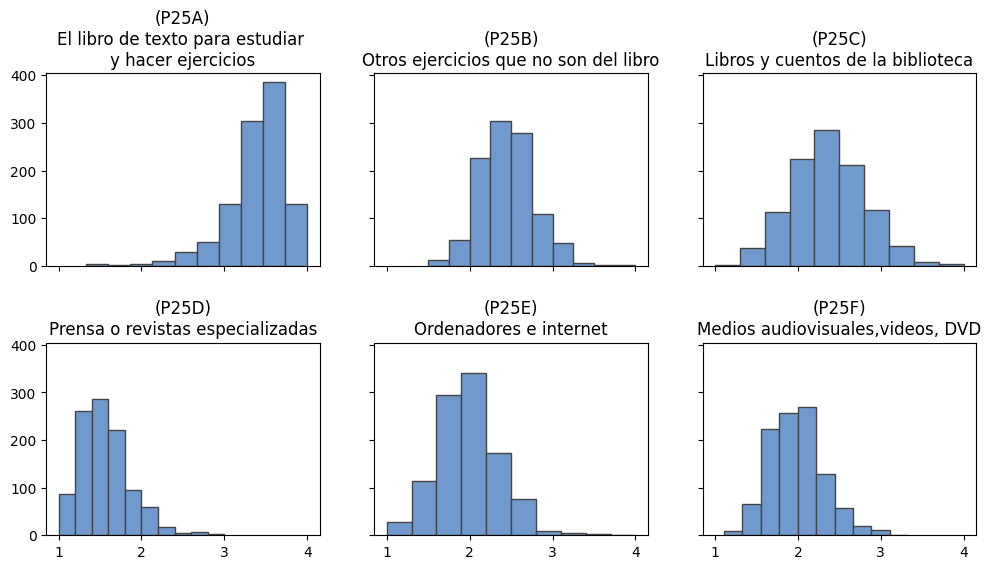

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6), ncols = 3, nrows = 2, sharey = True, sharex = True, gridspec_kw = {'hspace': 0.4})

ax[0,0].hist(df_tabla_train['P25A'], color ='#709acd' ,edgecolor = '#444444')
ax[0,1].hist(df_tabla_train['P25B'], color ='#709acd' ,edgecolor = '#444444')
ax[0,2].hist(df_tabla_train['P25C'], color ='#709acd' ,edgecolor = '#444444')
ax[1,0].hist(df_tabla_train['P25D'], color ='#709acd' ,edgecolor = '#444444')
ax[1,1].hist(df_tabla_train['P25E'], color ='#709acd' ,edgecolor = '#444444')
ax[1,2].hist(df_tabla_train['P25F'], color ='#709acd' ,edgecolor = '#444444')

ax[0,0].set_title('(P25A)\nEl libro de texto para estudiar \ny hacer ejercicios')
ax[0,1].set_title('(P25B)\nOtros ejercicios que no son del libro')
ax[0,2].set_title('(P25C)\nLibros y cuentos de la biblioteca')
ax[1,0].set_title('(P25D)\nPrensa o revistas especializadas')
ax[1,1].set_title('(P25E)\nOrdenadores e internet')
ax[1,2].set_title('(P25F)\nMedios audiovisuales,videos, DVD')


Y ahora las **Situaciones en clase**

Text(0.5, 1.0, '(P30E)\nEn general, respetamos\n las normas')

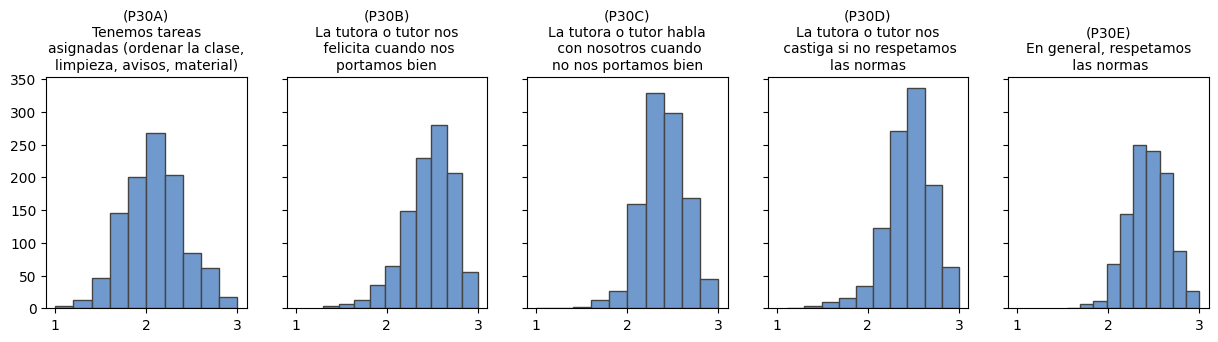

In [ ]:
fig, ax = plt.subplots(figsize = (15, 3), ncols = 5, sharey = True, sharex = True)

ax[0].hist(df_tabla_train['P30A'], color ='#709acd' ,edgecolor = '#444444')
ax[1].hist(df_tabla_train['P30B'], color ='#709acd' ,edgecolor = '#444444')
ax[2].hist(df_tabla_train['P30C'], color ='#709acd' ,edgecolor = '#444444')
ax[3].hist(df_tabla_train['P30D'], color ='#709acd' ,edgecolor = '#444444')
ax[4].hist(df_tabla_train['P30E'], color ='#709acd' ,edgecolor = '#444444')

ax[0].set_title('(P30A)\nTenemos tareas\nasignadas (ordenar la clase,\nlimpieza, avisos, material)', size = 10)
ax[1].set_title('(P30B)\nLa tutora o tutor nos\n felicita cuando nos\nportamos bien', size = 10)
ax[2].set_title('(P30C)\nLa tutora o tutor habla\n con nosotros cuando\nno nos portamos bien', size = 10)
ax[3].set_title('(P30D)\nLa tutora o tutor nos\n castiga si no respetamos\nlas normas', size = 10)
ax[4].set_title('(P30E)\nEn general, respetamos\n las normas', size = 10)



En esta ocasión, la escala se corresponde con:

1:	Nunca o casi nunca

2:	Algunas veces

3:	Siempre


# 8.2. Análisis bivariante

In [ ]:
# Nuevas correlaciones entre el promedio de las calificaciones y cada una de las tres variables de contexto del alumnado
corr = df_tabla_train[df_tabla_train.columns[1:]].corr('spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,Rendimiento,P24A,P24B,P24C,P24D,P24E,P24F,P24G,P24H,P25A,P25B,P25C,P25D,P25E,P25F,P30A,P30B,P30C,P30D,P30E,TITULAR,PP02_edad,PP04_antigdad,PP05_en_centro,PP10_retutor
Rendimiento,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24A,-0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24B,-0.07,0.34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24C,-0.02,0.46,0.41,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24D,0.06,0.24,0.16,0.34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24E,-0.25,0.19,0.25,0.30,0.22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24F,0.25,0.19,0.14,0.14,0.23,-0.07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24G,0.24,0.16,0.06,0.13,0.15,-0.11,0.33,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P24H,-0.28,0.10,0.22,0.14,0.10,0.36,-0.10,-0.42,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
P25A,0.33,0.21,0.17,0.18,0.23,0.01,0.37,0.34,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Tras un primer vistazo a la tabla anterior, yo destacaría que:
*   No hay correlaciones demasiado altas del Rendimiento con el resto de variables.
*   Tampoco del resto de variables entre sí, salvo los lógicos casos de la edad con la antigüedad o con la antigüedad en el centro
*   Aunque, con esas bajas correlaciones no se deberían sacar conclusiones muy fiables, no deja de llamarme la atención cómo el Rendimiento tiene una correlación positiva con algunas de las prácticas docentes más tradicionales y negativas con otras más innovadoras.




# **9. Minería de datos** (pendiente de realización)
Mi idea es aplicar una técnica de Clustering con el objetivo de categorizar al profesorado según sus similitudes en cuanto al estilo docente (tipo de prácticas, uso de materiales o recursos y gestión de las situaciones de clase), es decir, a partir de los valores recogidos en las respectivas 19 variables disponibles. Habría que usar un algoritmo de aprendizaje no supervisado pues, partimos de un database sin clases predeterminadas. También creo que no es conveniente obtener más de cuatro o cinco clústeres o “tipos” de profesores. Pensando en ello,  yo optaría por un algoritmo que, como el **K-means**, permita introducir el número de clusters. Aunque, disponiendo de tiempo, no dejaría de aplicar otros algoritmos de aprendizaje no supervisado como, por ejemplo, **Spectral Clustering**, que quizás pueda detectar más similitudes en una base de datos como ésta, en la que la heterogeneidad entre los datos del profesorado puede ser grande. Y, dependiendo de los valores que den la **accuracy** y otras métricas de la eficacia de estos algoritmos elegiría el mejor o me plantearía aplicar otro.


# **10. Validación con el conjunto de test**  (pendiente de realización)
Por supuesto, no hay que olvidar que habría que validar la eficacia de los modelos utilizados aplicándolos al conjunto de test

# **11. Discusión e interpretación de los resultados.**  (pendiente de realización)
Tras la aplicación de los algoritmos de clusterización, habrá que ver cómo queda caracterizado cada uno de los clusters o grupos de profesores y, por supuesto, luego se trataría de identificar qué tipologías de profesores consiguen un mayor rendimiento de su alumnado.
En el caso de que los resultados de esa clusterización no faciliten tanto la caracterización o la concreción de los criterios (en términos de prácticas docentes) con que se diferencia cada cluster, he pensado un plan alternativo que sería el de aplicar los algoritmos de Clustering, en lugar de atendiendo de forma conjunta a las 19 variables disponibles, hacerlo por separado atendiendo a cada uno de los tres bloques de variables que se corresponden con otros tantos aspectos del trabajo docente:
Tipo de trabajo en clase (variables de la P24A a la P24H)
Uso de materiales o recursos didácticos (variables de la P25A a la P25F)
Gestión de las situaciones en clase (variables de la P30A a la P30E)
Entiendo que de este modo sí será más sencillo identificar o caracterizar cada cluster o tipo de profesor, atendiendo por separado a cada uno de los tres aspectos anteriores. Luego, a la vista de las cantidades de profesores en cada cluster, entiendo que se podría hacer un interesante diagnóstico de cómo trabaja el profesorado de Ed. Primaria en España...
Pero, sobre todo, sería más factible identificar las prácticas docentes vinculadas a mejores rendimientos del alumnado, pues éste y no otro era el objetivo inicialmente planteado.

Por último, mencionar una última posibilidad de trabajo, independiente de lo anterior: veo muy factible la posibilidad de crear una nueva columna con una puntuación obtenida, para cada profesor tutor, según si sus prácticas o estilo docentes son más o menos innovadores o más o menos tradicionales, de modo que se pudiese clasificar al profesorado en cuatro categorías (de menos a más innovador). Posteriormente se podría hacer un análisis de los datos orientado a determinar qué tipo de profesores consiguen un mejor rendimiento o si existe alguna correlación (positiva o negativa) entre el grado de innovación del profesorado y el rendimiento de su alumnado. Solo que este tipo de análisis quizás sea sólo eso, un análisis bivariante o multivariante y no llegue a requerir algoritmos de Minería de datos.
